# Definitions
- Definir estações
- Artigo para ler: https://latamt.ieeer9.org/index.php/transactions/article/view/5563
- Plotar hora a hora, e o describe
- Transformação logaritmica, para variacia não constante?
- Método Box-Cox ou deflacionar a série
- Modelar a serie temporal
  - Normality hypothesis tests, Anderson-Darling and Shapiro-Wilk
  - Decompor em 3 partes: tendência, sazonalidade e resíduo
- Aplicar estacionariedade
- Verificar precipitação, quando tiver.
- A press atmo do nivel da estacao ja é a media
- Usar temp. Bulbo seco
- Agrupar por estacoes do ano (verao, inverno, etc)
- Corte as 5h as 21h
- Verificar umidade no litoral
- Pegar estacoes proximas, ir do litoral ao interior
- Pegar principalmente duas regioes (bahia e sul, por exemplo)
- Transfer learning entre estacoes nas regioes


### Escolhendo estações
  - Dados de Curitiba (A807), Z1
  - Dados de Pelotas (A887), Z2
  - Dados de Belo Horizonte pampulha (A521), Z3
  - Dados de Brasilia (A001), Z4
  - Dados de Governador Valadares (A532), Z5
  - Dados de Campo Grande (A702), Z6
  - Dados de Mossoró (A318), Z7,
  - Dados de Manaus (A101), Z8


### Imports

In [7]:
%run UtilsNew.ipynb

In [8]:
l_datasets = ["brasilia", 
              "curitiba", 
              "manaus", 
              "campo_grande", 
              "minas_gerais_bh", 
              "minas_gerais_gv",
              "pelotas",
              "mossoro"]

l_raw_data = []

for i in l_datasets:
    l_raw_data.append(pd.read_csv("data/" + i + ".csv", sep=";"))

In [9]:
# l_raw_data[0]

### Informações dos datasets

In [10]:
dict_result = {}
for i, j in zip(l_raw_data, l_datasets):
    buffer = io.StringIO()
    i["Radiacao (KJ/m²)"].info(buf=buffer)
    s = buffer.getvalue()
    total = s.split("\n")[1].split(": ")[1].split(" ")[0]
    non_null = s.split("\n")[5].split(" ")[0]
    dict_result[j] = [int(total), int(non_null)]

df_nulls = pd.DataFrame.from_dict(dict_result, orient='index')
# df_nulls.columns
df_nulls["Percentual de registros não nulos"] = df_nulls[1]/df_nulls[0]
df_nulls = df_nulls.reset_index().rename(columns={"index":"estacao"})

<Axes: xlabel='estacao', ylabel='Percentual de registros não nulos'>

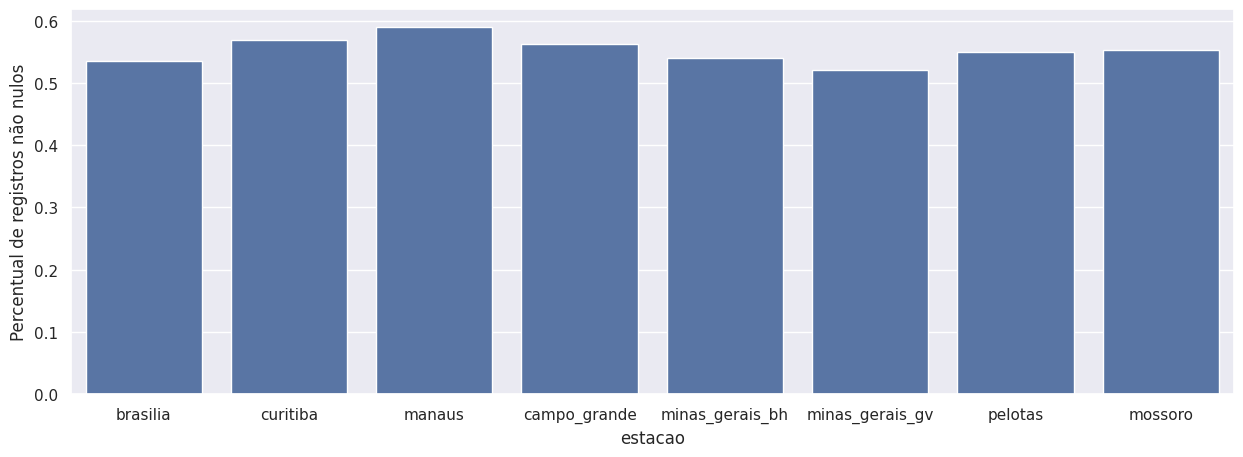

In [11]:
set_size_plot(15, 5)
sns.barplot(df_nulls[["estacao", "Percentual de registros não nulos"]], x="estacao", y="Percentual de registros não nulos")

In [55]:
df_nulls[["estacao", "Percentual de registros não nulos"]]

,estacao,Percentual de registros não nulos
0,brasilia,0.534950
1,curitiba,0.568761
2,manaus,0.589481
3,campo_grande,0.562614
4,minas_gerais_bh,0.540187
5,minas_gerais_gv,0.521175
6,pelotas,0.550319
7,mossoro,0.553279


### Pre processamento

In [12]:
dict_processed = {}
for i, j in zip(l_raw_data, l_datasets):
    dict_processed[j] = pre_processing(i)

### Remoção de horários

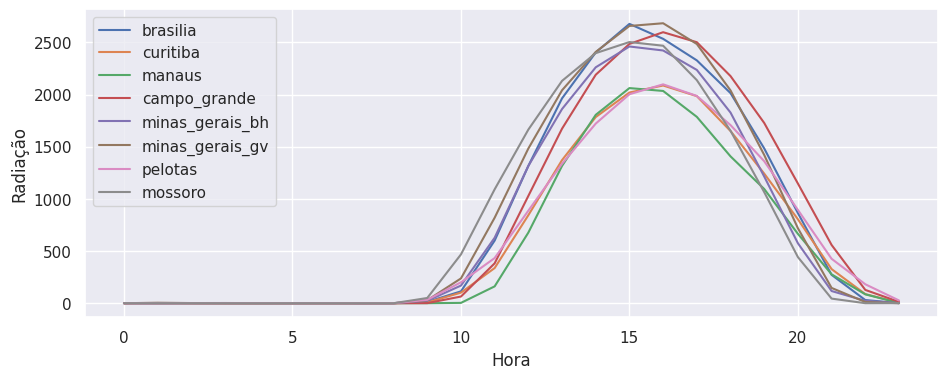

In [13]:
set_plot_size(11, 4)

plt.ylabel('Radiação')
plt.xlabel('Hora')
for i in dict_processed.keys():
    df_hour_mean = dict_processed[i][["hora", "radiacao"]].groupby(['hora'])\
    ['radiacao'].agg(['mean']).reset_index().rename(columns={"mean":i})
    sns.lineplot(data=df_hour_mean, x='hora', y=i, label=i)


### Algumas estatisticas

In [14]:
numeric_cols = ['float16', 'float32', 'float64']
l_df_stats = []

for i in dict_processed.keys():
    series = dict_processed[i]\
    .select_dtypes(include=numeric_cols)\
    .describe()[["radiacao", "temp_ins_c"]].T[["mean", "std"]].T["radiacao"]

    l_df_stats.append(pd.DataFrame([series]).T.rename(columns={"radiacao":i}).T)

pd.concat(l_df_stats)

,mean,std
brasilia,1445.162098,1077.879755
curitiba,1064.731865,987.404321
manaus,945.425647,949.897577
campo_grande,1380.342028,1104.924469
minas_gerais_bh,1319.394099,1026.059399
minas_gerais_gv,1448.235627,1131.445416
pelotas,1144.556806,1076.929002
mossoro,1364.135082,975.247824


### Correlação

In [17]:
corr = dict_processed["mossoro"].select_dtypes(include=numeric_cols).corr()

<Axes: >

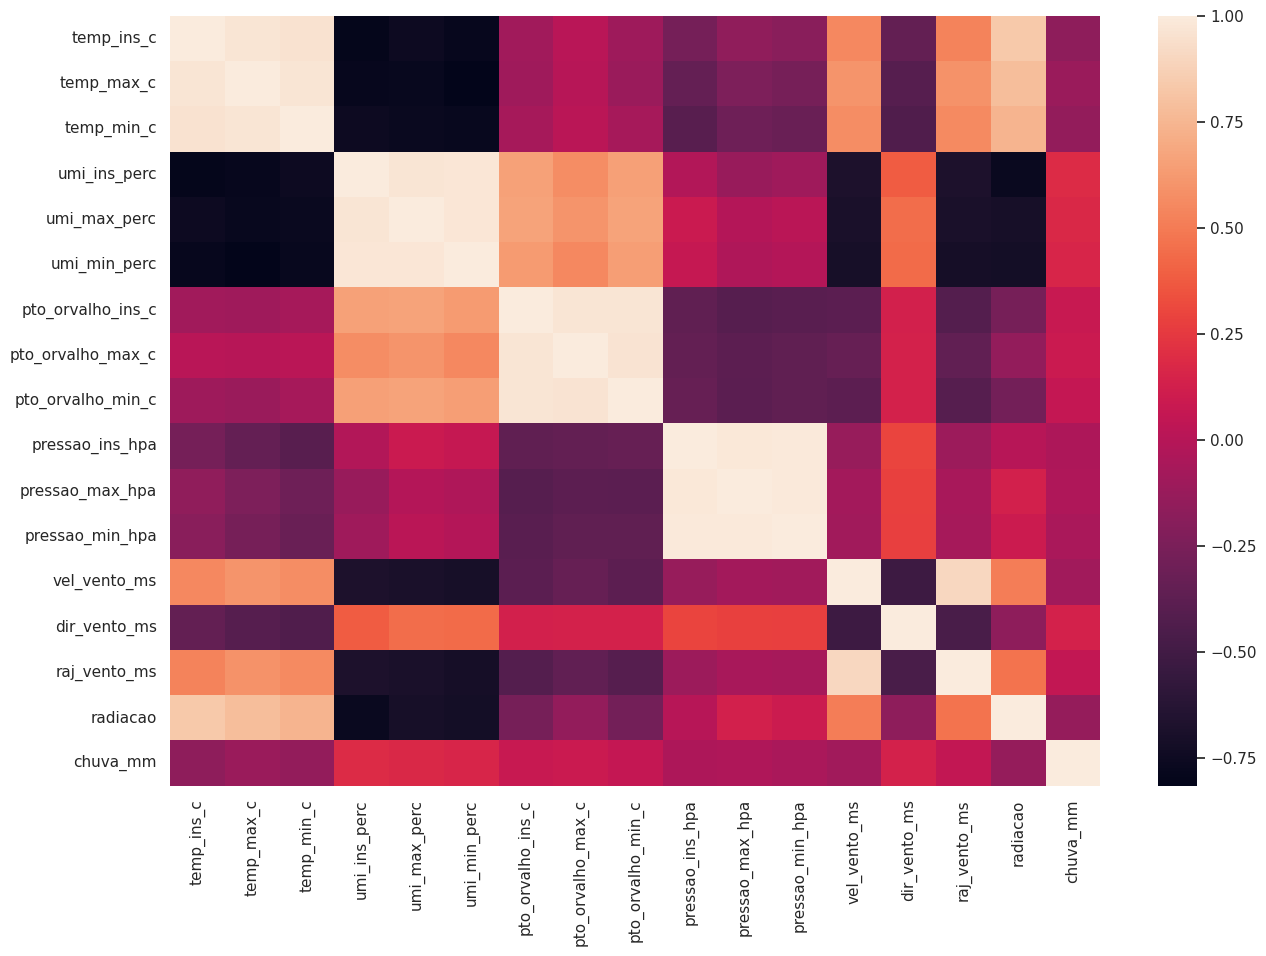

In [18]:
set_plot_size(15, 10)
sns.heatmap(corr)

In [19]:
dict_processed["mossoro"]\
.select_dtypes(include=numeric_cols)\
[["umi_ins_perc", "temp_ins_c", "radiacao", "vel_vento_ms"]]\
.corr()

,umi_ins_perc,temp_ins_c,radiacao,vel_vento_ms
umi_ins_perc,1.000000,-0.796748,-0.772206,-0.680919
temp_ins_c,-0.796748,1.000000,0.831753,0.552346
radiacao,-0.772206,0.831753,1.000000,0.503956
vel_vento_ms,-0.680919,0.552346,0.503956,1.000000


### Serie temporal

In [20]:
dict_processed.keys()

dict_keys(['brasilia', 'curitiba', 'manaus', 'campo_grande', 'minas_gerais_bh', 'minas_gerais_gv', 'pelotas', 'mossoro'])

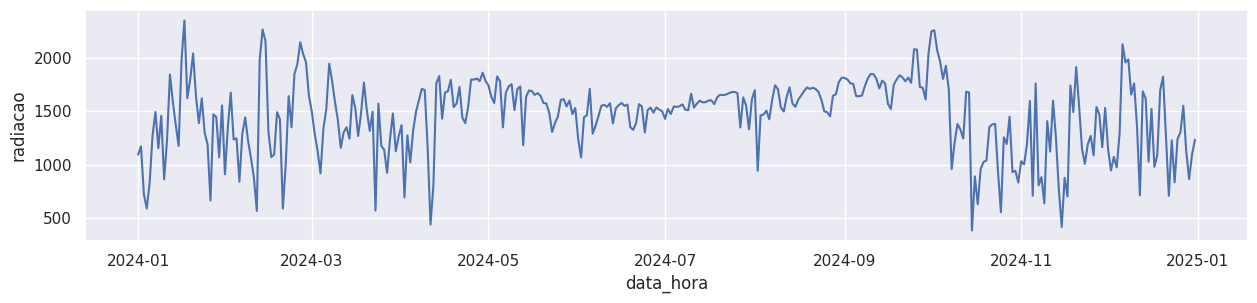

In [35]:
set_plot_size(15, 3)

series_brasilia = dict_processed["brasilia"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_brasilia.resample("D").mean(), x="data_hora", y="radiacao")


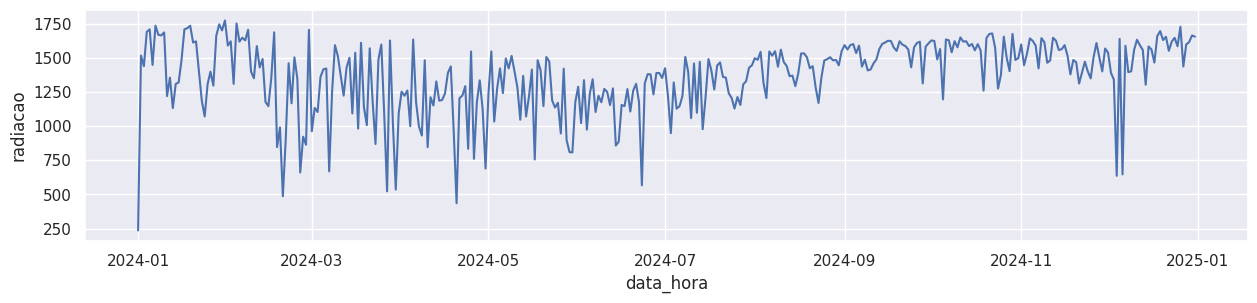

In [36]:
series_mossoro = dict_processed["mossoro"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_mossoro.resample("D").mean(), x="data_hora", y="radiacao")

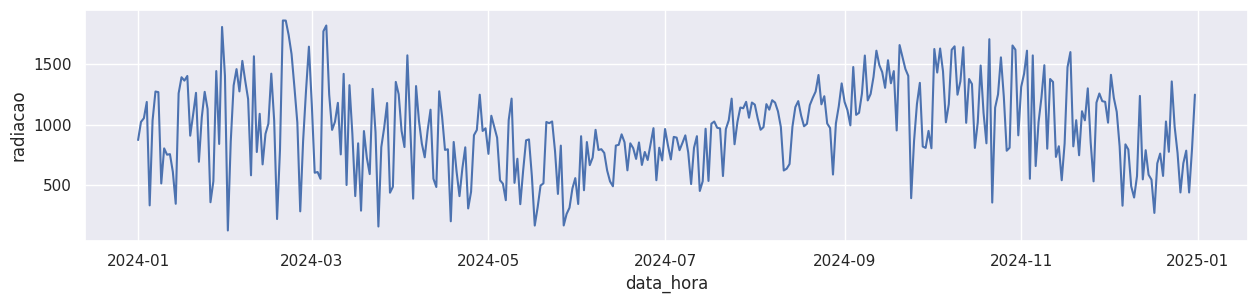

In [37]:
series_manaus = dict_processed["manaus"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_manaus.resample("D").mean(), x="data_hora", y="radiacao")

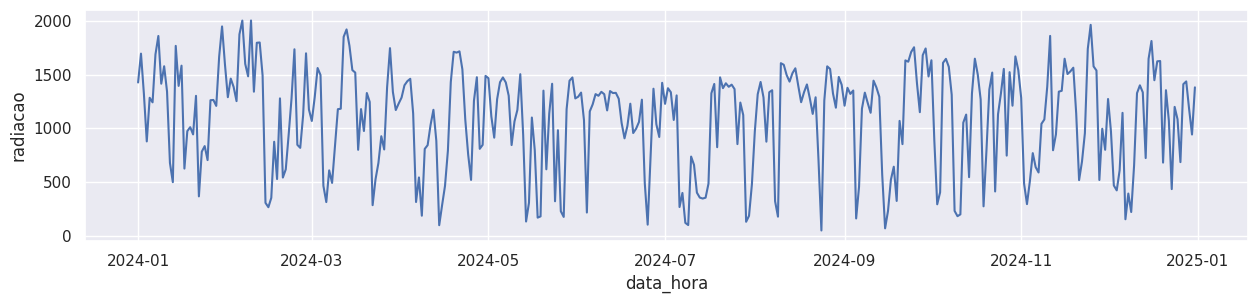

In [38]:
series_ctb = dict_processed["curitiba"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_ctb.resample("D").mean(), x="data_hora", y="radiacao")

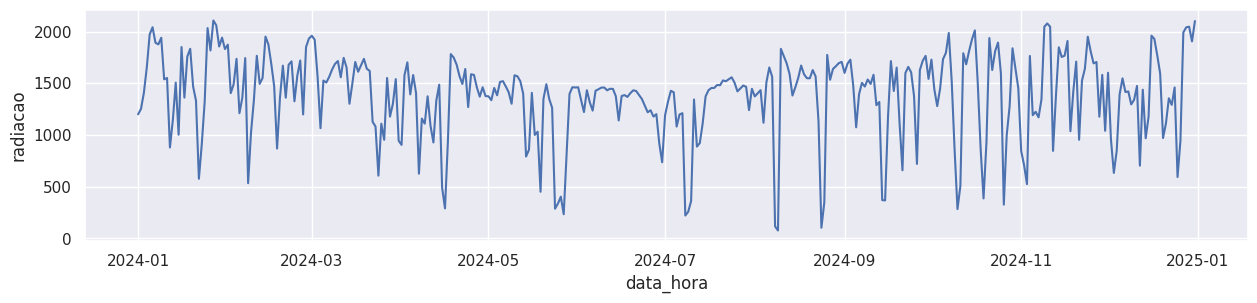

In [39]:
series_campo_grande = dict_processed["campo_grande"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_campo_grande.resample("D").mean(), x="data_hora", y="radiacao")

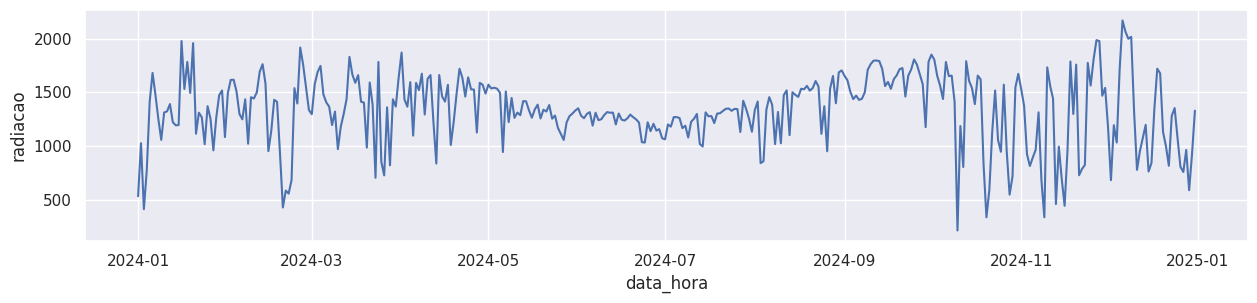

In [40]:
series_bh = dict_processed["minas_gerais_bh"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_bh.resample("D").mean(), x="data_hora", y="radiacao")

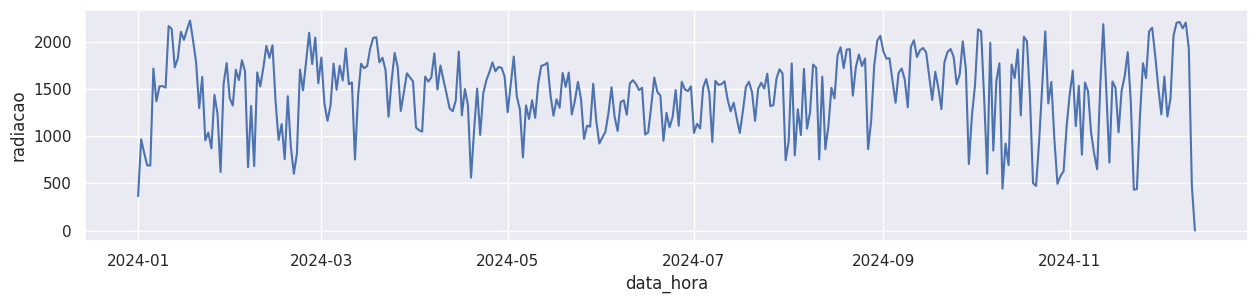

In [41]:
series_gv = dict_processed["minas_gerais_gv"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_gv.resample("D").mean(), x="data_hora", y="radiacao")

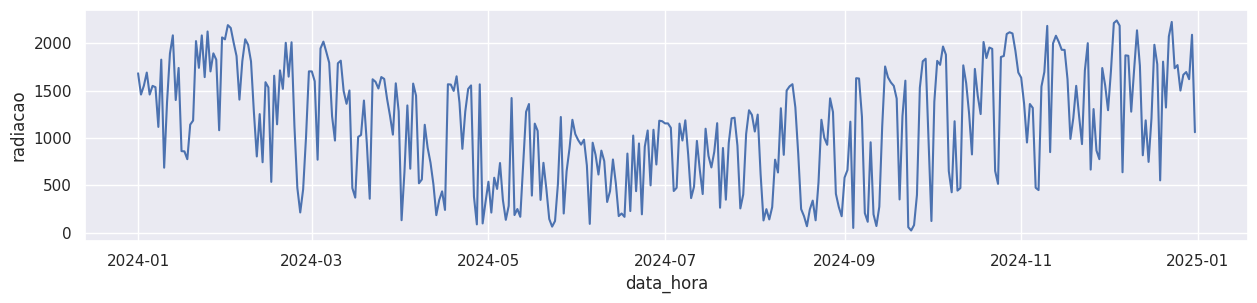

In [42]:
series_pelotas = dict_processed["pelotas"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_pelotas.resample("D").mean(), x="data_hora", y="radiacao")

### Estacionariedade AdFuler

In [29]:
import statsmodels.tsa.stattools as ts

def adfuller_test(df):
    result=ts.adfuller(df)
    labels = ['Teste estatístico ADF','p-valor','Num Lags','Numero de observações']
    for value, label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.")
    else:
        print("Fracas evidências contra a hipotese nula(Ho), a série temporal possui uma raíz unitária, indicando que é não estacionária.")

In [30]:
adfuller_test(series_brasilia["radiacao"])

Teste estatístico ADF : -7.228225732994673
p-valor : 2.0265490139301207e-10
Num Lags : 31
Numero de observações : 4667
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [43]:
adfuller_test(series_mossoro["radiacao"])

Teste estatístico ADF : -7.073101114478738
p-valor : 4.879499317917876e-10
Num Lags : 32
Numero de observações : 4827
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [44]:
adfuller_test(series_manaus["radiacao"])

Teste estatístico ADF : -9.33656552777091
p-valor : 9.029658840254766e-16
Num Lags : 30
Numero de observações : 5147
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [45]:
adfuller_test(series_ctb["radiacao"])

Teste estatístico ADF : -10.74672357494209
p-valor : 2.7298366039172857e-19
Num Lags : 23
Numero de observações : 4972
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [46]:
adfuller_test(series_campo_grande["radiacao"])

Teste estatístico ADF : -9.596917632516014
p-valor : 1.9670885538209985e-16
Num Lags : 29
Numero de observações : 4912
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [47]:
adfuller_test(series_bh["radiacao"])

Teste estatístico ADF : -7.399036002904435
p-valor : 7.641344526228884e-11
Num Lags : 31
Numero de observações : 4713
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [48]:
adfuller_test(series_gv["radiacao"])

Teste estatístico ADF : -8.251285126788588
p-valor : 5.382402394560683e-13
Num Lags : 30
Numero de observações : 4547
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [50]:
adfuller_test(series_pelotas["radiacao"])

Teste estatístico ADF : -6.853382838870461
p-valor : 1.6720857181748553e-09
Num Lags : 28
Numero de observações : 4805
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


### Teste de media movel

<Axes: >

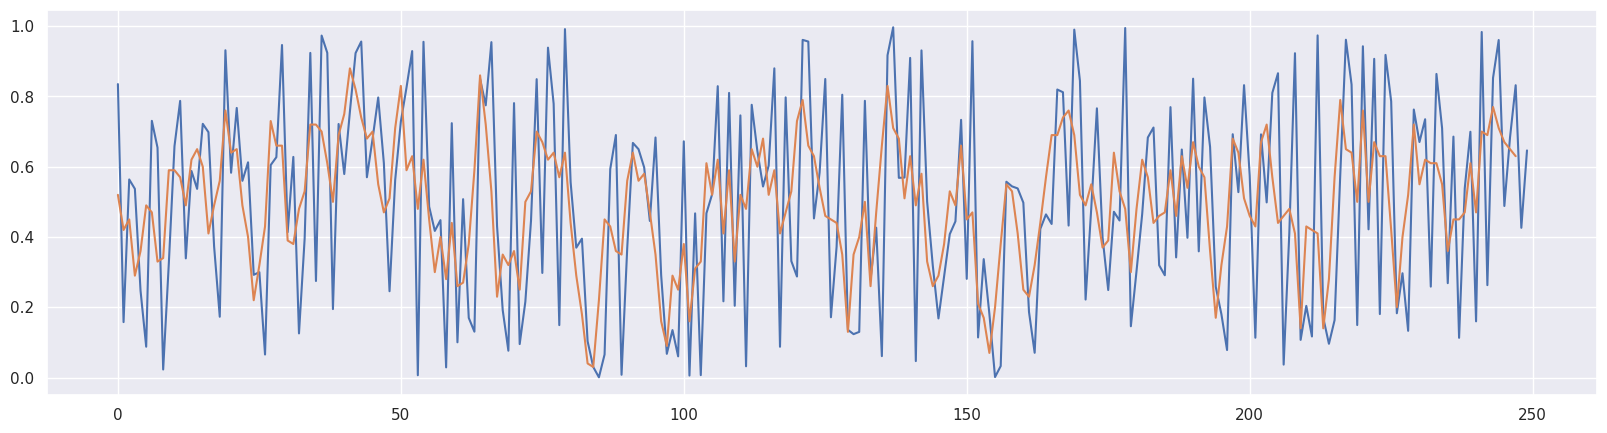

In [45]:
import numpy as np
 
arr = []

for i in range(0, 250):
    rng2 = np.random.default_rng()
    arr.append(rng2.random())  

window_size = 3

i = 0
moving_averages = []

while i < len(arr) - window_size + 1:

	window = arr[i : i + window_size]

	window_average = round(sum(window) / window_size, 2)
	
	moving_averages.append(window_average)
	
	i += 1

set_plot_size(20, 5)
sns.lineplot(arr)
sns.lineplot(moving_averages)

### Media movel

<Axes: xlabel='data_hora', ylabel='radiacao'>

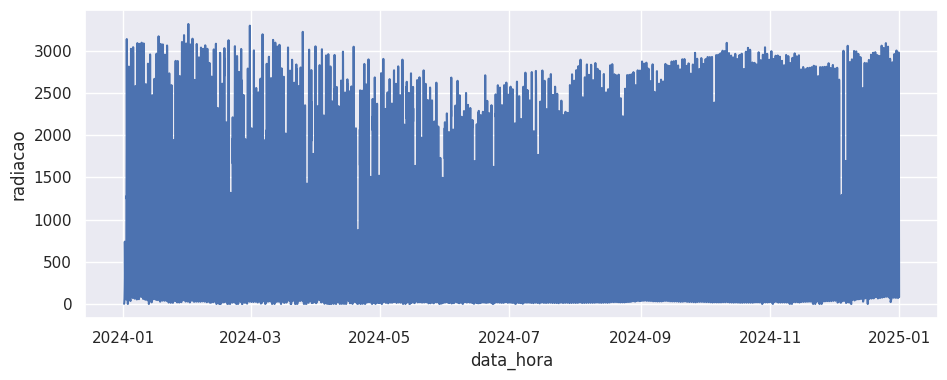

In [38]:
sns.lineplot(data=dict_processed["rio_grande_do_norte"], x="data_hora", y="radiacao")

<Axes: xlabel='data_hora', ylabel='media_movel'>

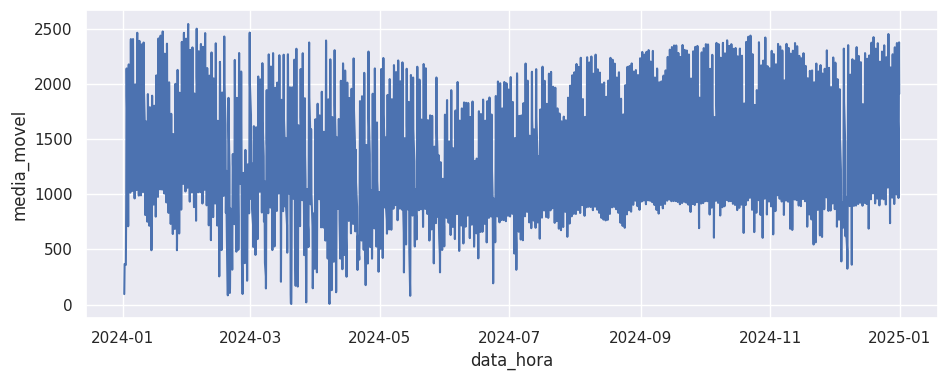

In [39]:
df_test = dict_processed["rio_grande_do_norte"]
df_test["media_movel"] = df_test.radiacao.rolling(8).mean()
sns.lineplot(data=df_test, x="data_hora", y="media_movel")

In [81]:
df_test[["data_hora", "radiacao", "media_movel"]].head(10)

,data_hora,radiacao,media_movel
10,2023-01-01 10:00:00,166.5,NaN
11,2023-01-01 11:00:00,1081.6,NaN
12,2023-01-01 12:00:00,1700.4,NaN
13,2023-01-01 13:00:00,2894.6,NaN
14,2023-01-01 14:00:00,3332.9,NaN
15,2023-01-01 15:00:00,3552.7,NaN
16,2023-01-01 16:00:00,3496.3,NaN
17,2023-01-01 17:00:00,3085.2,2413.7750
18,2023-01-01 18:00:00,2516.8,2707.5625
19,2023-01-01 19:00:00,1710.1,2786.1250


### Aumento e aceleração

<Axes: xlabel='data', ylabel='aumento'>

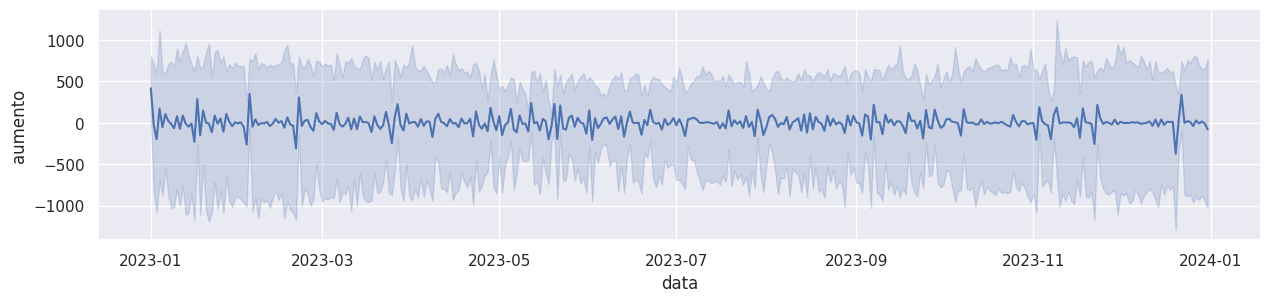

In [82]:
df_test = filter_between(df, "hora", 10, 17)
df_test['aumento'] = df_test.radiacao.diff()
sns.lineplot(data=df_test, x="data", y="aumento")

<Axes: xlabel='data', ylabel='aceleracao'>

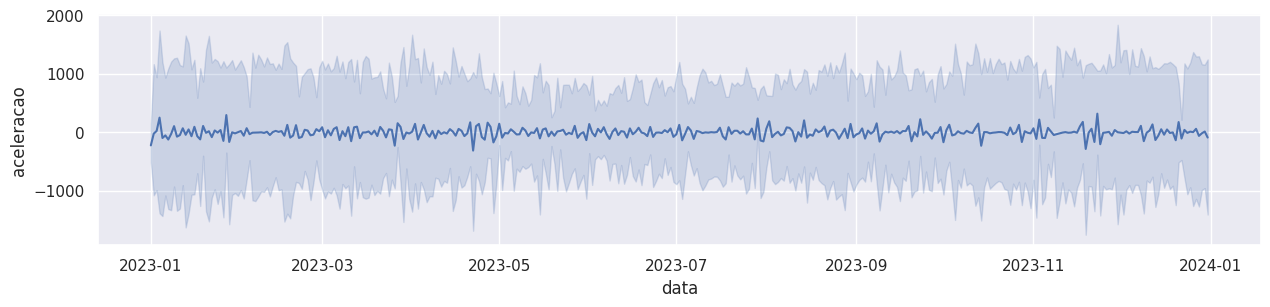

In [83]:
df_test['aceleracao'] = df_test.aumento.diff()
sns.lineplot(data=df_test, x="data", y="aceleracao")

### Autocorrelação

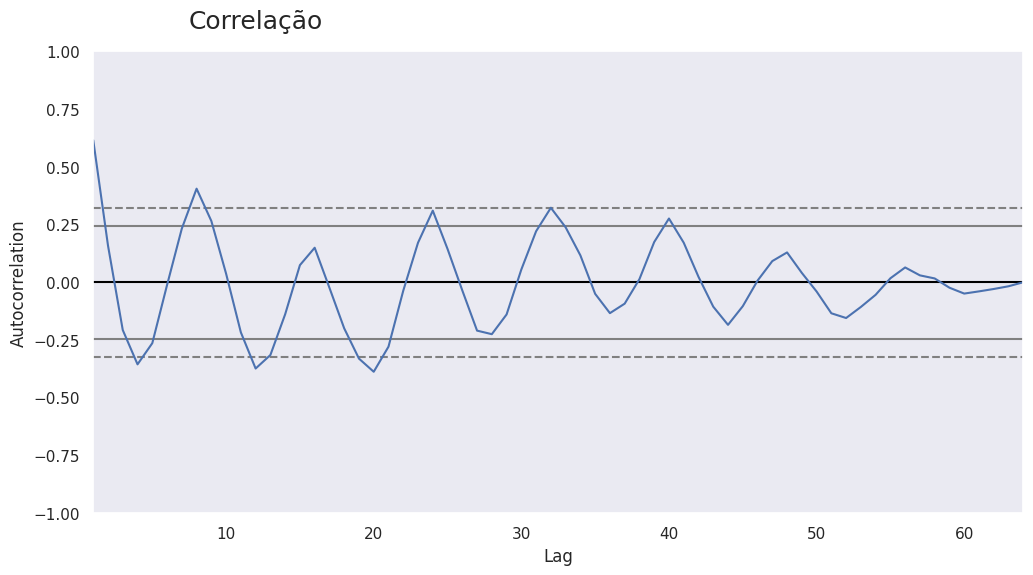

In [84]:
df_test = filter_between(df, "hora", 10, 17)
df_test = filter_between(df_test, "data", "2023-03-21", "2023-03-28")
ax = plt.figure(figsize=(12,6))
ax.suptitle("Correlação", fontsize=18, x=0.26, y=0.95)
autocorrelation_plot(df_test.radiacao)
ax=ax

### Decomposição

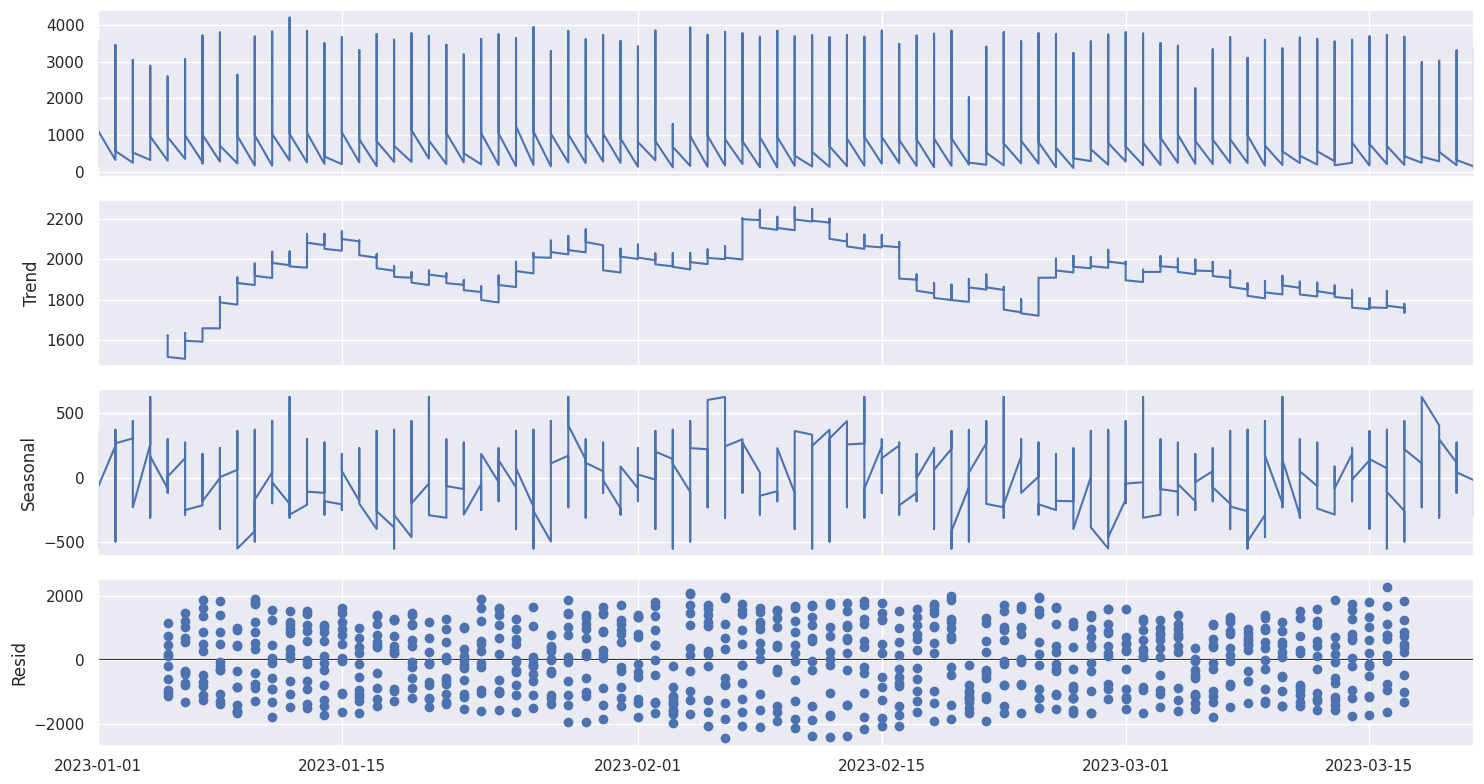

In [85]:
set_plot_size(15, 8)
df_test = filter_between(df, "hora", 6, 21)
df_test = filter_between(df_test, "data", "2023-01-01", "2023-03-21")

resultado = seasonal_decompose(df_test[["radiacao", "data"]].set_index('data'), period=90)
ax = resultado.plot()

### Box-Cox

In [87]:
# Importar bibliotecas
from scipy.stats import boxcox
# Calcular melhor valor de lambda para a série temporal
df_box_cox = filter_between(df, "data", "2023-01-01", "2023-03-21")
df_box_cox = filter_between(df_box_cox, "hora", 10, 17)
serie_temporal2, lambda_boxcox = boxcox(df_box_cox["radiacao"])

In [88]:
df_box_cox["rad"] = serie_temporal2

<Axes: xlabel='data', ylabel='rad'>

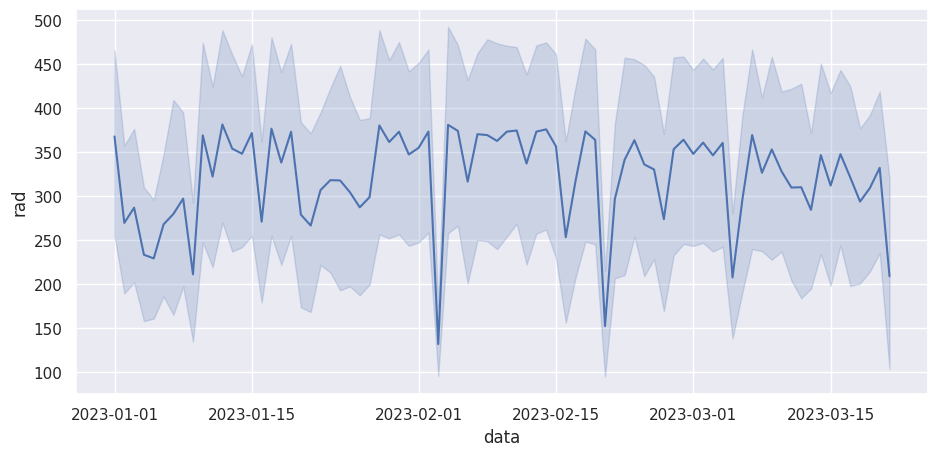

In [89]:
set_plot_size(11, 5)
sns.lineplot(data=df_box_cox, x="data", y="rad")